# Bayesian Data Analysis - Project Work

## Introduction

We have selected for our problem to analyse how precipitation has changed among the years from 1981 to 2010 in Helsinki and whether it is rising. In this case, our approach is to use bayesian methods to regress a predictive model into the precipitation data, which we have obtained from Ilmatieteenlaitos (https://en.ilmatieteenlaitos.fi/statistics-from-1961-onwards). We have described our problem and approach more precisely in the following introduction sub chapters "Description of the data and the problem", "Description of the model" and "Description of the prior choices".

### Description of the data and the problem


In this project we are going to apply linear regression to analyze whether precipitation in Helsinki is rising. We are going to use yearly precipitation data from https://en.ilmatieteenlaitos.fi/statistics-from-1961-onwards, which contains 57 data points (from year 1961 to 2017). The data points include the year, the precipitation for the year and precipitation percentage from 1981-2010 average. In this case, we are going to ignore the precipitation percentage for simplicity, and focus only on one feature. The feature is the year and the target is the precipitation for the year. Below, we have plotted the data points.

In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np

,Category,Precipitation,Precipitation percentage from 1981-2010 average
0,1961,570.6,87
1,1962,751.1,114
2,1963,529.5,81
3,1964,462.7,71
4,1965,601.0,92


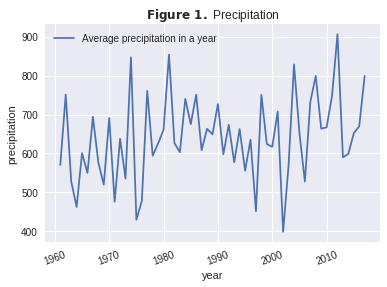

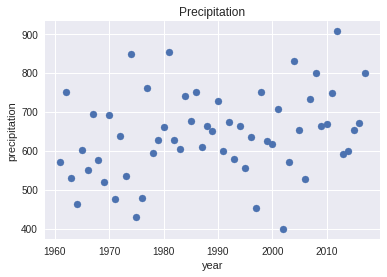

In [ ]:
df_helsinki = pd.read_csv("helsinki.csv", sep=';')
display(HTML(df_helsinki.head(5).to_html(max_rows=5)))
plt.plot(df_helsinki.Category.values, df_helsinki.Precipitation, label=("Average precipitation in a year"))           
plt.title(r'$\bf{Figure\ 1.}$ Precipitation')
plt.xlabel('year')
plt.ylabel('precipitation')
plt.xticks(rotation=20)
plt.legend()

plt.figure()
plt.scatter(np.array(df_helsinki.Category.values), np.array(df_helsinki.Precipitation.values), label=("Average precipitation"))    
plt.title('Precipitation')
plt.xlabel('year')
plt.ylabel('precipitation')

plt.show()



The data is balanced, but the values have high range, thus it is necessary to standardize the data before the process. To make it clear, we have tabulated only the five first data points to get an overview of the raw data.

### Description of the model

To analyze whether precipitation is rising, we will implement a linear Gaussian model with adjustable priors. As can be seen from the plots above, there is quite a bit of seemingly random variation in the data. We will try to explain the variation in the data with the Gaussian model. In other words, the model for the precipitation is y ~ N(mu, sigma), where mu = alpha + beta*x. The variable x represents the year.

We will standardize the data, as the x values, or the years, are far away from zero. This removes the strong posterior dependency between alpha and beta, which are the parameters for the model. After the necessary calculations, we will transform the values back to the original scale.

### Description of the prior choices

The goal for prior choices is to rule out unreasonable parameter values but not to be so strong as to rule out values that make sense. The idea is that the loss in precision by making the prior a bit too weak is less serious than the gain in robustness by including parts of parameter space that might be relevant. Thus, we will use conjugate, weakly informative priors.

The precipitations are yearly averages, which makes it somewhat likely that they are normally distributed. Additionally, we believe that a priori increase or decrease are as likely. The first prior we test is for both alpha and beta N(0, 1), which is suitable and generally used for standardized data. However, it is possible that this prior is too restrictive. For this reason, we will also test a very weak prior N(0, 10) for both alpha and beta.

In [ ]:
!pip install pystan

    100% |████████████████████████████████| 50.0MB 932kB/s 
    100% |████████████████████████████████| 2.1MB 10.7MB/s 


In [ ]:
import pystan

In [ ]:
def compile_model(filename):
    with open(filename) as f:
        model_code = f.read()
        sm = pystan.StanModel(model_code=model_code)

        return sm
      
def check_div(fit):
    """Check transitions that ended with a divergence"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    divergent = [x for y in sampler_params for x in y['divergent__']]
    n = sum(divergent)
    N = len(divergent)
    print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))
    if n > 0:
        print('Try running with larger adapt_delta to remove the divergences')

def check_treedepth(fit, max_depth = 10):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    depths = [x for y in sampler_params for x in y['treedepth__']]
    n = sum(1 for x in depths if x == max_depth)
    N = len(depths)
    print(('{} of {} iterations saturated the maximum tree depth of {}'
            + ' ({}%)').format(n, N, max_depth, 100 * n / N))
    if n > 0:
        print('Run again with max_depth set to a larger value to avoid saturation')

def check_energy(fit):
    """Checks the energy Bayesian fraction of missing information (E-BFMI)"""
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    for chain_num, s in enumerate(sampler_params):
        energies = s['energy__']
        numer = sum((energies[i] - energies[i - 1])**2 for i in range(1, len(energies))) / len(energies)
        denom = np.var(energies)
        if numer / denom < 0.2:
            print('Chain {}: E-BFMI = {}'.format(chain_num, numer / denom))
            print('E-BFMI below 0.2 indicates you may need to reparameterize your model')

In [ ]:
x = df_helsinki.Category.values
y = df_helsinki.Precipitation
N = len(x)
xpred = 2018

data_weak_priors = dict(
    N=N,
    x=x,
    y=y,
    xpred=xpred,
    pmualpha=0,
    psalpha=1,
    pmubeta=0,
    psbeta=1
)

data_super_weak_priors = dict(
    N=N,
    x=x,
    y=y,
    xpred=xpred,
    pmualpha=0,
    psalpha=10,
    pmubeta=0,
    psbeta=10
)

## Run Stan

In [ ]:
model = compile_model('linear_gaussian.stan')
fit = model.sampling(data=data_weak_priors, seed=194838)
super_weak_fit = model.sampling(data=data_super_weak_priors, seed=194838)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e067c71047389aa094a5d1c16ea328ae NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp_8461nie/stanfit4anon_model_e067c71047389aa094a5d1c16ea328ae_1077319695997290516.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Check the n_eff and Rhat for model with priors N(0, 1):

In [ ]:
print(fit)

Inference for Stan model: anon_model_e067c71047389aa094a5d1c16ea328ae.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       8.9e-4  2.2e-3   0.13  -0.26  -0.09 2.7e-4   0.09   0.26   3741    1.0
beta          0.27  2.2e-3   0.13 1.2e-3   0.18   0.27   0.35   0.53   3728    1.0
sigma_std     0.99  1.6e-3    0.1   0.82   0.92   0.98   1.05   1.21   3675    1.0
mu_std[1]    -0.45  4.3e-3   0.26  -0.96  -0.63  -0.46  -0.28   0.08   3719    1.0
mu_std[2]    -0.43  4.2e-3   0.26  -0.93   -0.6  -0.44  -0.27   0.08   3715    1.0
mu_std[3]    -0.42  4.1e-3   0.25   -0.9  -0.58  -0.42  -0.26   0.08   3712    1.0
mu_std[4]     -0.4  4.0e-3   0.24  -0.87  -0.56  -0.41  -0.24   0.08   3709    1.0
mu_std[5]    -0.39  3.9e-3   0.24  -0.84  -0.54  -0.39  -0.23   0.08   3705    1.0
mu_std[6]    -0.37  3.8e-3   0.23  -0.81  -0.52  -0.37  -0.22   

Check the n_eff and Rhat for model with priors N(0, 10):

In [ ]:
print(super_weak_fit)

Inference for Stan model: anon_model_e067c71047389aa094a5d1c16ea328ae.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       1.8e-3  2.2e-3   0.13  -0.26  -0.09 3.6e-3   0.09   0.26   3718    1.0
beta          0.28  2.2e-3   0.13   0.02   0.19   0.28   0.36   0.53   3505    1.0
sigma_std     0.99  1.7e-3    0.1   0.82   0.92   0.99   1.05   1.21   3222    1.0
mu_std[1]    -0.47  4.5e-3   0.26  -0.96  -0.64  -0.47   -0.3   0.05   3394    1.0
mu_std[2]    -0.45  4.4e-3   0.25  -0.93  -0.62  -0.45  -0.28   0.06   3400    1.0
mu_std[3]    -0.43  4.2e-3   0.25   -0.9   -0.6  -0.43  -0.27   0.06   3408    1.0
mu_std[4]    -0.42  4.1e-3   0.24  -0.87  -0.58  -0.42  -0.26   0.06   3416    1.0
mu_std[5]     -0.4  4.0e-3   0.23  -0.84  -0.56   -0.4  -0.24   0.06   3424    1.0
mu_std[6]    -0.38  3.9e-3   0.23  -0.82  -0.54  -0.38  -0.23   

Check the treedepth, E-BFMI, and divergences:

In [ ]:
print('Model with priors N(0,1):')
check_treedepth(fit)
check_energy(fit)
check_div(fit)

print('\nModel with priors N(0,10):')
check_treedepth(super_weak_fit)
check_energy(super_weak_fit)
check_div(super_weak_fit)

Model with priors N(0,1):
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)

Model with priors N(0,10):
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
0.0 of 4000 iterations ended with a divergence (0.0%)


Below we can see that with the standardized data there is not much posterior correlation for either of the models:

Text(0.5,1,'N(0,10)')

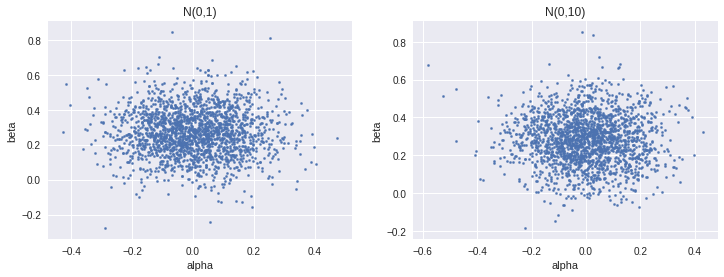

In [ ]:
samples = fit.extract(permuted=True)
super_weak_samples = super_weak_fit.extract(permuted=True)

figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 2  # width
#figsize[1] *= 2.5  # height
fig, axes = plt.subplots(1, 2, figsize=figsize)

ax = axes[0]
ax.scatter(samples['alpha'][:2000], samples['beta'][:2000], 5)
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_title('N(0,1)')

ax = axes[1]
ax.scatter(super_weak_samples['alpha'][:2000], super_weak_samples['beta'][:2000], 5)
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_title('N(0,10)')

Probability that precipitation is increasing:

In [ ]:
print('Model with priors N(0,1):')
print('Pr(beta > 0) = {}'.format(np.mean(samples['beta'] > 0)))

print('\nModel with priors N(0, 10):')
print('Pr(beta > 0) = {}'.format(np.mean(super_weak_samples['beta'] > 0)))

Model with priors N(0,1):
Pr(beta > 0) = 0.9755

Model with priors N(0, 10):
Pr(beta > 0) = 0.9815


Mean of the prediction for the year 2018:

In [ ]:
print('Mean of ypred with priors N(0, 1) = {}'.format(np.mean(samples['ypred'])))

print('\nMean of ypred with priors N(0, 10) = {}'.format(np.mean(super_weak_samples['ypred'])))

Mean of ypred with priors N(0, 1) = 693.8226323120855

Mean of ypred with priors N(0, 10) = 695.934820174552


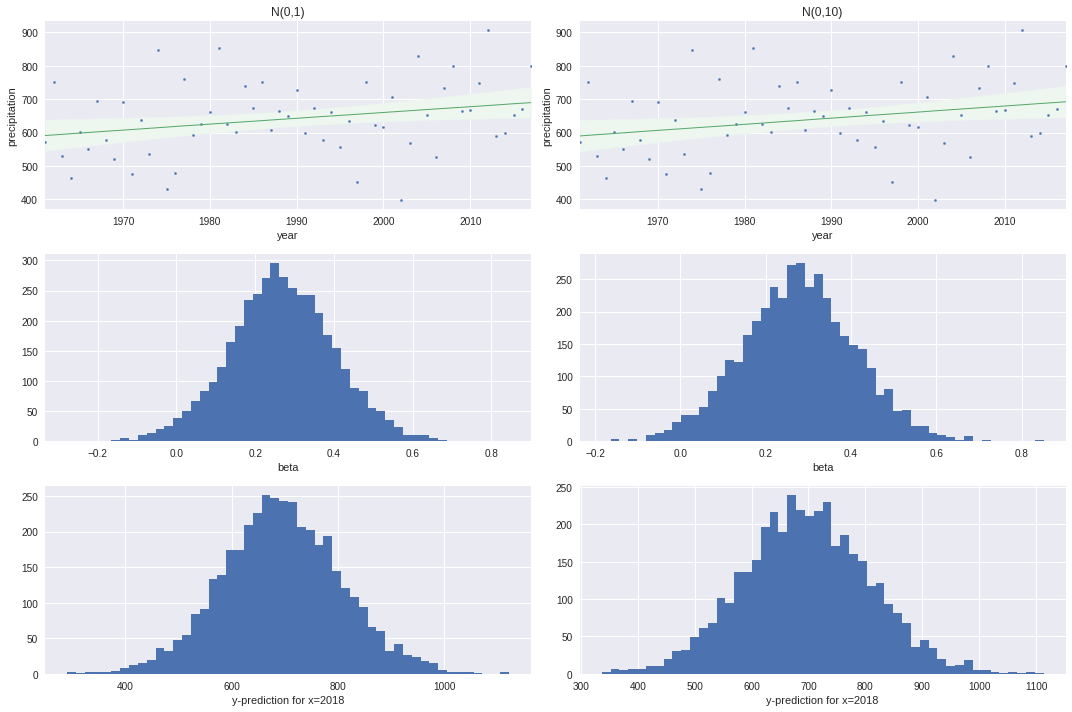

In [ ]:
# make slightly wider figure of 3 plots
figsize = plt.rcParams['figure.figsize'].copy()
figsize[0] *= 2.5  # width
figsize[1] *= 2.5  # height
fig, axes = plt.subplots(3, 2, figsize=figsize)

# plot 1: scatterplot and lines
color_scatter = 'C0'  # 'C0' for default color #0
color_line = 'C1'     # 'C1' for default color #1
# lighten color_line
color_shade = (
    1 - 0.1*(1 - np.array(mpl.colors.to_rgb(color_line)))
)
# plot
ax = axes[0][0]
ax.fill_between(
    x,
    np.percentile(samples['mu'], 5, axis=0),
    np.percentile(samples['mu'], 95, axis=0),
    color=color_shade
)
ax.plot(
    x,
    np.percentile(samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)
ax.scatter(x, y, 5, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('precipitation')
ax.set_xlim((1961, 2017))
ax.set_title('N(0,1)')

ax = axes[0][1]
ax.fill_between(
    x,
    np.percentile(super_weak_samples['mu'], 5, axis=0),
    np.percentile(super_weak_samples['mu'], 95, axis=0),
    color=color_shade
)
ax.plot(
    x,
    np.percentile(super_weak_samples['mu'], 50, axis=0),
    color=color_line,
    linewidth=1
)
ax.scatter(x, y, 5, color=color_scatter)
ax.set_xlabel('year')
ax.set_ylabel('precipitation')
ax.set_xlim((1961, 2017))
ax.set_title('N(0,10)')

# plot 2: histogram
ax = axes[1][0]
ax.hist(samples['beta'], 50)
ax.set_xlabel('beta')

ax = axes[1][1]
ax.hist(super_weak_samples['beta'], 50)
ax.set_xlabel('beta')

# plot 3: histogram
ax = axes[2][0]
ax.hist(samples['ypred'], 50)
ax.set_xlabel('y-prediction for x={}'.format(xpred))

ax = axes[2][1]
ax.hist(super_weak_samples['ypred'], 50)
ax.set_xlabel('y-prediction for x={}'.format(xpred))

# make figure compact
fig.tight_layout()

plt.show()

### The Stan Code

In [ ]:
with open('linear_gaussian.stan') as file:
    print(file.read())

// Gaussian linear model with standardized data
data {
  int<lower=0> N; // number of data points
  vector[N] x; //
  vector[N] y; //
  real xpred; // input location for prediction
  real pmualpha; // prior mean for alpha
  real psalpha;  // prior std for alpha
  real pmubeta;  // prior mean for beta
  real psbeta;   // prior std for beta
}
transformed data {
  vector[N] x_std;
  vector[N] y_std;
  real xpred_std;
  x_std = (x - mean(x)) / sd(x);
  y_std = (y - mean(y)) / sd(y);
  xpred_std = (xpred - mean(x)) / sd(x);
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma_std;
}
transformed parameters {
  vector[N] mu_std;
  mu_std = alpha + beta*x_std;
}
model {
  alpha ~ normal(pmualpha, psalpha);
  beta ~ normal(pmubeta, psbeta);
  y_std ~ normal(mu_std, sigma_std);
}
generated quantities {
  vector[N] mu;
  real<lower=0> sigma;
  real ypred;
  vector[N] log_lik;
  mu = mu_std*sd(y) + mean(y);
  sigma = sigma_std*sd(y);
  ypred = normal_rng((alpha + beta*xpred_std)*sd(y)+m

##  Convergence Diagnostics


For both of the models, Rhat values are exactly 1.0, n_eff values are large enough and none of the iterations saturated the maximum tree depth of 10 or ended with a divergence. These factors make it fair to assume that the fits are successful and the iterations have converged.

## Posterior Predictive Checking

To make sure our model is reasonable we can compare the drawn samples of the model to the original data points to see if our model generates approximately same data. In this case, we will make a quick test and take our prediction of the year 2018, which average is 693 with the weak prior and see, if it makes sense according to the data. The generated data point average seems to be reasonable .

However, we can see from the visualized regression of our model hypothesis among the original data points that it fits poorly. The data points are scattered in great range around, and the hypothesis can only predict the between average. Thus it is not quite reliable to use for exact prediction, but it can be used to see, if the  average precipitation is rising.

## Model Comparison

To compare the models that resulted from the two different priors, we apply LOO cross validation. The first prior is weak with distribution N(0, 1) and the other is very weak with distribution N(0, 10).

samples Loo: -348.84509912593796
samples Ks: [ 0.11241377  0.24776654  0.03074809  0.12682159 -0.01490508  0.02933241
  0.15546824  0.02974977  0.01786208  0.17165336  0.0452657   0.06146334
  0.02573217  0.09195953  0.07983878  0.12252664  0.07960304 -0.05177079
 -0.11141244 -0.00306501 -0.0090333  -0.0723351  -0.03430314  0.08094621
 -0.04238571  0.05159065  0.0097933  -0.05219248 -0.08376427 -0.01059355
 -0.01793445 -0.00853669 -0.04170976 -0.03701463  0.10680883 -0.05183657
  0.10429235  0.00387595  0.03492214  0.09878887  0.05390194  0.25067155
  0.12477951 -0.04058225  0.00117956  0.1671957   0.08747888  0.0158258
  0.07387845  0.07888464  0.13187147  0.07580996  0.15833087  0.14764984
  0.22555337  0.23719542  0.06550449]
Weak samples Loo: -348.82986319872424
Weak samples Ks: [ 0.04692485  0.17042272  0.07744185  0.12379842  0.15863224  0.06436226
  0.13704038 -0.05609719  0.0050286   0.19045635  0.06404349  0.17330171
 -0.08537841  0.19855063  0.06481402  0.01964034  0.04804943

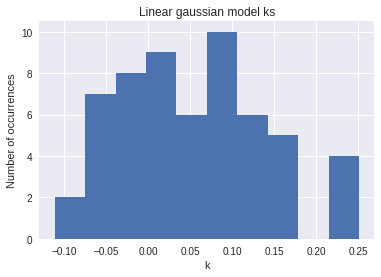

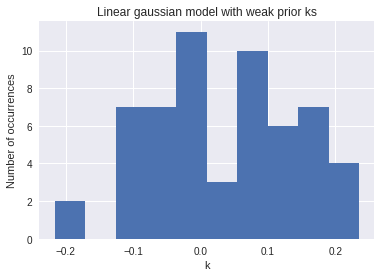

In [ ]:
import psis

samples_loo, samples_loos, samples_ks = psis.psisloo(samples.get('log_lik'))
weak_samples_loo, weak_samples_loos, weak_samples_ks = psis.psisloo(super_weak_samples.get('log_lik'))

print("samples Loo:", samples_loo)
print("samples Ks:", samples_ks)
print("Weak samples Loo:", weak_samples_loo)
print("Weak samples Ks:", weak_samples_ks)

plt.figure()
plt.hist(samples_ks)
plt.title('Linear gaussian model ks')
plt.xlabel('k')
plt.ylabel('Number of occurrences')

plt.figure()
plt.hist(weak_samples_ks)
plt.title('Linear gaussian model with weak prior ks')
plt.xlabel('k')
plt.ylabel('Number of occurrences')
plt.show()

The k values from both models are below 0.7, which means the models should both be reliable. Additionally, the Loo values and the results from the fits of the models are very similar and sensible. Therefore, the prior choice doesn't have a large effect in this case and the models perform too similarly to make conclusions about which is better.

## Conclusion

As mentioned, the resulting models are both seemingly reliable. Using the model with priors N(0, 1), for example, the probability for the beta value, or the slope of the fitted linear model, being positive is roughly 97.6%. Its mean is 0.27 and 95% interval is [1.2e-3, 0.53]. These values indicate that precipitation in Helsinki is likely indeed rising, albeit slightly.

## Discussion Of Problems, And Potential Improvements

In this case, the models provide seemingly reliable information, but still, our data set is relatively small and simple in the perspective of features. It is possible to increase the reliability by gathering more data points and features, such as precipitation percentage. As described in this document, the data was simplified. We could use all the available features and compare its results to our simplified results. Even if the linear regression seems to fit well into the data, we don't know if it's underfitted. It could be informative to try polynomial regression to see if there is light non-linear changes in the precipitation. Lastly, it could be useful to try more different priors to see whether that impacts the results.